# 1. Main Code

##### Import data

In [1]:
import pandas as pd
import math

In [2]:
#Import Korean_airports data
airports_df = pd.read_csv("Korean_airports.csv")
airports_df

,Name,Type,IATA,ICAO,Longitude (deg),Latitude (deg)
0,Incheon,International,ICN,RKSI,126.449800,37.446500
1,Jeju,International,CJU,RKPC,126.624120,33.384605
2,Cheongju,International,CJJ,RKTU,127.498900,36.716400
3,Yangyang,International,YNY,RKNY,128.668900,38.061100
4,Pohang,Domestic,KPO,RKTH,129.420500,35.987900
5,Gimhae,International,PUS,RKPK,128.938100,35.179400
6,Gimpo,International,GMP,RKSS,126.993183,37.213614


In [3]:
#Import Korean_airways data
airways_df = pd.read_csv("Korean_airways.csv")
airways_df = airways_df[airways_df['Start Longitude (deg)']<130] 
airways_df

,Name,Start Longitude (deg),Start Latitude (deg),End Longitude (deg),End Latitude (deg)
0,A582,127.348575,36.838358,127.500925,36.714367
1,A582,127.500925,36.714367,127.819172,36.453422
2,A582,127.819172,36.453422,128.029970,36.279140
3,A582,128.029970,36.279140,128.590770,35.809835
4,A582,128.590770,35.809835,128.774025,35.503350
...,...,...,...,...,...
164,Y685,127.952743,36.843677,127.796357,36.931610
165,Z53,128.029970,36.279140,127.991360,36.561385
166,G597,128.135278,37.606944,128.584444,37.675556
167,Y697,128.135278,37.606944,128.584444,37.675556


##### Visualize the data

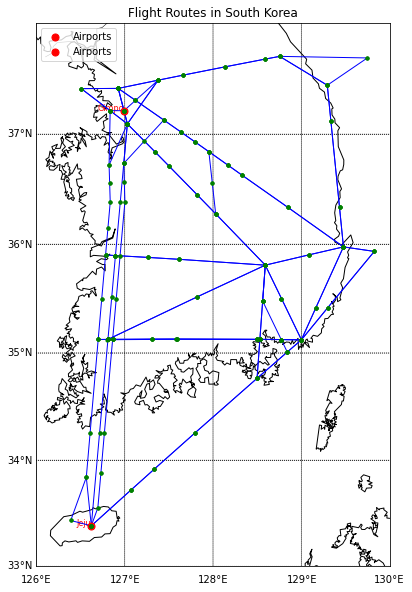

In [4]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, LineString

# Initialize the plot
fig, ax = plt.subplots(figsize=(8, 10))

# Create a Basemap instance
m = Basemap(llcrnrlon=126, llcrnrlat=33, urcrnrlon=130, urcrnrlat=38, resolution='i', projection='merc', ax=ax)

# Draw coastlines and country borders
m.drawcoastlines()
m.drawcountries()

# Draw parallels and meridians
m.drawparallels(range(33, 38, 1), labels=[1,0,0,0])
m.drawmeridians(range(125, 132, 1), labels=[0,0,0,1])

# Plotting airports
x, y = m(airports_df['Longitude (deg)'].values, airports_df['Latitude (deg)'].values)


# Annotating airports
for (name, xpt, ypt) in zip(airports_df['Name'], x, y):
    if name in ['Gimpo', 'Jeju']:
        plt.text(xpt, ypt, name, fontsize=8, ha='right', color='red')
        plt.scatter(xpt, ypt, color='red', marker='o', s=50, zorder=5, label='Airports')

# Plotting airways and points
for idx, row in airways_df.iterrows():
    start_lon, start_lat = row['Start Longitude (deg)'], row['Start Latitude (deg)']
    end_lon, end_lat = row['End Longitude (deg)'], row['End Latitude (deg)']
    x, y = m([start_lon, end_lon], [start_lat, end_lat])
    m.plot(x, y, color='blue', linewidth=1, linestyle='-', zorder=4)
    m.scatter(x, y, color='green', marker='o', s=10, zorder=5)  # Adding green points at airways

# Title and labels
plt.title('Flight Routes in South Korea')
plt.legend(loc='upper left')

# Show the plot
plt.show()


##### Haversine function

In [5]:
import numpy as np

# Haversine formula to calculate the distance between two geographical points
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of the Earth in kilometers
    dlon = np.radians(lon2 - lon1)
    dlat = np.radians(lat2 - lat1)
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Calculate distances for all airways and add them as weights
airways_df['Weight'] = airways_df.apply(
    lambda row: haversine(row['Start Longitude (deg)'], row['Start Latitude (deg)'], 
                          row['End Longitude (deg)'], row['End Latitude (deg)']), axis=1)


airways_df.head()


,Name,Start Longitude (deg),Start Latitude (deg),End Longitude (deg),End Latitude (deg),Weight
0,A582,127.348575,36.838358,127.500925,36.714367,19.344404
1,A582,127.500925,36.714367,127.819172,36.453422,40.612232
2,A582,127.819172,36.453422,128.029970,36.279140,27.051894
3,A582,128.029970,36.279140,128.590770,35.809835,72.562918
4,A582,128.590770,35.809835,128.774025,35.503350,37.888564


## 1) Under the clear weather

##### Implement A* algorithm

In [6]:
import heapq

# Create a graph representation
graph = {}
for _, row in airways_df.iterrows():
    start = (row['Start Longitude (deg)'], row['Start Latitude (deg)'])
    end = (row['End Longitude (deg)'], row['End Latitude (deg)'])
    weight = row['Weight']
    if start not in graph:
        graph[start] = []
    if end not in graph:
        graph[end] = []
    graph[start].append((end, weight))
    graph[end].append((start, weight))  # Assuming bidirectional airways

# Define the heuristic function
def heuristic(node, goal):
    return haversine(node[0], node[1], goal[0], goal[1])

# A* algorithm implementation
def a_star(graph, start, goal):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {node: float('inf') for node in graph}
    g_score[start] = 0
    f_score = {node: float('inf') for node in graph}
    f_score[start] = heuristic(start, goal)
    
    #Repeat while open_set is not empty
    while open_set:
        _, current = heapq.heappop(open_set)
        
        # Selecting the node with the lowest f_score
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]
        
        # Check neighbor
        for neighbor, weight in graph[current]:
            tentative_g_score = g_score[current] + weight
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, goal)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))
    
    return None

# Get coordinates for Gimpo and Jeju
gimpo_coords = airports_df[airports_df['Name'] == 'Gimpo'][['Longitude (deg)', 'Latitude (deg)']].values[0]
jeju_coords = airports_df[airports_df['Name'] == 'Jeju'][['Longitude (deg)', 'Latitude (deg)']].values[0]


In [7]:
from scipy.spatial import KDTree

# Create a list of all nodes (coordinates) in the graph
nodes = list(graph.keys())

# Create a KDTree for fast nearest-neighbor lookup
kdtree = KDTree(nodes)

# Function to find the nearest node in the graph to a given point
def find_nearest_node(point):
    _, idx = kdtree.query(point)
    return nodes[idx]

# Find the nearest nodes to the coordinates of Gimpo and Jeju airports
start = find_nearest_node(tuple(gimpo_coords))
goal = find_nearest_node(tuple(jeju_coords))

# Find the shortest path using A* algorithm
path = a_star(graph, start, goal)

# Display the result
path

/Users/sdyplum/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[(126.9931833, 37.21361389),
 (127.0316667, 37.09436944),
 (126.9909903, 36.73705139),
 (126.9514333, 36.38625278),
 (126.8969425, 35.89779972),
 (126.8553833, 35.52115),
 (126.8121194, 35.12623581),
 (126.7170492, 34.25407056),
 (126.6241196, 33.38460522)]

In [8]:
# total distance
total_distance = 0
for i in range(len(path) - 1):
    lon1, lat1 = path[i]
    lon2, lat2 = path[i + 1]
    total_distance += haversine(lon1, lat1, lon2, lat2)

print(f"Total distance: {total_distance} km")

Total distance: 427.85374155469265 km


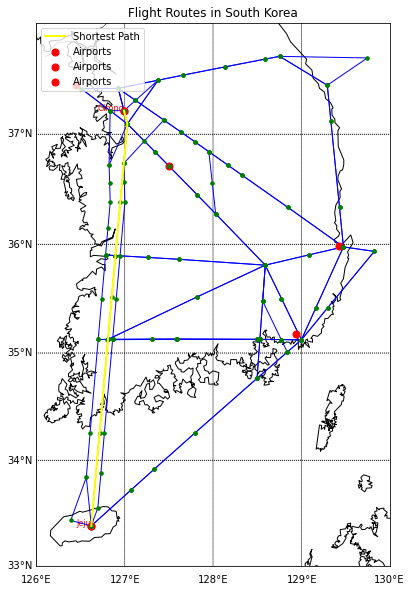

In [9]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(8, 10))

# Create a Basemap instance
m = Basemap(llcrnrlon=126, llcrnrlat=33, urcrnrlon=130, urcrnrlat=38, resolution='i', projection='merc', ax=ax)

# Draw coastlines and country borders
m.drawcoastlines()
m.drawcountries()

# Draw parallels and meridians
m.drawparallels(range(33, 38, 1), labels=[1,0,0,0])
m.drawmeridians(range(125, 132, 1), labels=[0,0,0,1])

# Plotting airports
x, y = m(airports_df['Longitude (deg)'].values, airports_df['Latitude (deg)'].values)
m.scatter(x, y, color='red', marker='o', s=50, zorder=5, label='Airports')

# Annotating airports
for (name, xpt, ypt) in zip(airports_df['Name'], x, y):
    if name in ['Gimpo', 'Jeju']:
        plt.text(xpt, ypt, name, fontsize=8, ha='right', color='red')
        plt.scatter(xpt, ypt, color='red', marker='o', s=50, zorder=5, label='Airports')

# Plotting airways and points
for idx, row in airways_df.iterrows():
    start_lon, start_lat = row['Start Longitude (deg)'], row['Start Latitude (deg)']
    end_lon, end_lat = row['End Longitude (deg)'], row['End Latitude (deg)']
    x, y = m([start_lon, end_lon], [start_lat, end_lat])
    m.plot(x, y, color='blue', linewidth=1, linestyle='-', zorder=4)
    m.scatter(x, y, color='green', marker='o', s=10, zorder=5)  # Adding green points at airways

# Plotting the shortest path
path_lons, path_lats = zip(*path)
x, y = m(path_lons, path_lats)
m.plot(x, y, color='yellow', linewidth=2, linestyle='-', zorder=6, label='Shortest Path')

# Title and labels
plt.title('Flight Routes in South Korea')
plt.legend(loc='upper left')

# Show the plot
plt.show()


In [10]:
# Create a graph representation
graph = {}
for _, row in airways_df.iterrows():
    start = (row['Start Longitude (deg)'], row['Start Latitude (deg)'])
    end = (row['End Longitude (deg)'], row['End Latitude (deg)'])
    weight = row['Weight']
    if start not in graph:
        graph[start] = []
    if end not in graph:
        graph[end] = []
    graph[start].append((end, weight))
    graph[end].append((start, weight))  # Assuming bidirectional airways

# Display the graph
graph

{(127.348575, 36.83835833): [((127.500925, 36.71436667), 19.344403897482156),
  ((127.0316667, 37.09436944), 40.038619195066055),
  ((127.500925, 36.71436667), 19.344403897482156),
  ((127.0316667, 37.09436944), 40.038619195066055)],
 (127.500925, 36.71436667): [((127.348575, 36.83835833), 19.344403897482156),
  ((127.8191722, 36.45342222), 40.612231737684354),
  ((127.348575, 36.83835833), 19.344403897482156),
  ((127.8191722, 36.45342222), 40.612231737684354)],
 (127.8191722, 36.45342222): [((127.500925, 36.71436667), 40.612231737684354),
  ((128.0299697, 36.27914028), 27.05189393964307),
  ((127.500925, 36.71436667), 40.612231737684354),
  ((128.0299697, 36.27914028), 27.05189393964307)],
 (128.0299697, 36.27914028): [((127.8191722, 36.45342222), 27.05189393964307),
  ((128.5907703, 35.80983494), 72.56291773343138),
  ((127.8191722, 36.45342222), 27.05189393964307),
  ((128.5907703, 35.80983494), 72.56291773343138),
  ((127.9913598, 36.56138491), 31.573739041449638)],
 (128.5907703,

## 2) Under the severe weather

In [11]:
# Define the severe weather polygon
severe_weather_polygon = Polygon([(126.4, 34.6), (127.1, 34.6), (127.1, 34.2), (126.4, 34.2)])

# Function to check if a point is within the polygon
def is_within_polygon(point, polygon):
    return polygon.contains(Point(point))

# Create a modified graph excluding nodes and edges within the severe weather polygon
modified_graph = {}
for node in graph:
    if not is_within_polygon(node, severe_weather_polygon):
        filtered_edges = []
        for edge in graph[node]:
            if not is_within_polygon(edge[0], severe_weather_polygon):
                filtered_edges.append(edge)
        if filtered_edges:
            modified_graph[node] = filtered_edges

# Get coordinates for Gimpo and Jeju
gimpo_coords = airports_df[airports_df['Name'] == 'Gimpo'][['Longitude (deg)', 'Latitude (deg)']].values[0]
jeju_coords = airports_df[airports_df['Name'] == 'Jeju'][['Longitude (deg)', 'Latitude (deg)']].values[0]

# Find the nearest nodes to the coordinates of Gimpo and Jeju airports
start = find_nearest_node(tuple(gimpo_coords))
goal = find_nearest_node(tuple(jeju_coords))

# Find the shortest path using A* algorithm on the modified graph
path = a_star(modified_graph, start, goal)

# Display the result
path


[(126.9931833, 37.21361389),
 (127.0316667, 37.09436944),
 (127.348575, 36.83835833),
 (127.500925, 36.71436667),
 (127.8191722, 36.45342222),
 (128.0299697, 36.27914028),
 (128.5907703, 35.80983494),
 (128.5609923, 35.47970869),
 (128.529722, 35.1266665),
 (128.4976922, 34.76535483),
 (127.792902, 34.25466028),
 (127.331378, 33.91454919),
 (127.0730556, 33.72222222),
 (126.6241196, 33.38460522)]

In [12]:
## total distance ####
total_distance = 0
for i in range(len(path) - 1):
    lon1, lat1 = path[i]
    lon2, lat2 = path[i + 1]
    total_distance += haversine(lon1, lat1, lon2, lat2)

print(f"Total distance: {total_distance} km")

Total distance: 560.7155840514827 km


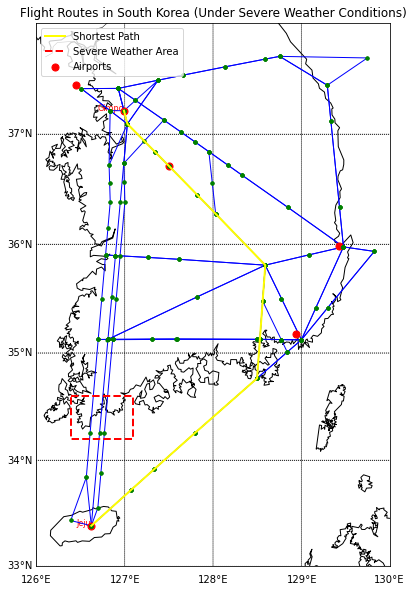

In [13]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(8, 10))

# Create a Basemap instance
m = Basemap(llcrnrlon=126, llcrnrlat=33, urcrnrlon=130, urcrnrlat=38, resolution='i', projection='merc', ax=ax)

# Draw coastlines and country borders
m.drawcoastlines()
m.drawcountries()

# Draw parallels and meridians
m.drawparallels(range(33, 38, 1), labels=[1,0,0,0])
m.drawmeridians(range(125, 132, 1), labels=[0,0,0,1])

# Plotting airports
x, y = m(airports_df['Longitude (deg)'].values, airports_df['Latitude (deg)'].values)
m.scatter(x, y, color='red', marker='o', s=50, zorder=5, label='Airports')

# Annotating airports
for (name, xpt, ypt) in zip(airports_df['Name'], x, y):
    if name in ['Gimpo', 'Jeju']:
        plt.text(xpt, ypt, name, fontsize=8, ha='right', color='red')

# Plotting airways and points
for idx, row in airways_df.iterrows():
    start_lon, start_lat = row['Start Longitude (deg)'], row['Start Latitude (deg)']
    end_lon, end_lat = row['End Longitude (deg)'], row['End Latitude (deg)']
    x, y = m([start_lon, end_lon], [start_lat, end_lat])
    m.plot(x, y, color='blue', linewidth=1, linestyle='-', zorder=4)
    m.scatter(x, y, color='green', marker='o', s=10, zorder=5)  # Adding green points at airways

# Plotting the shortest path
if path:
    path_lons, path_lats = zip(*path)
    x, y = m(path_lons, path_lats)
    m.plot(x, y, color='yellow', linewidth=2, linestyle='-', zorder=6, label='Shortest Path')

# Plotting the severe weather polygon
wx, wy = zip(*severe_weather_polygon.exterior.coords)
wx, wy = m(wx, wy)
m.plot(wx, wy, color='red', linewidth=2, linestyle='--', zorder=7, label='Severe Weather Area')

# Title and labels
plt.title('Flight Routes in South Korea (Under Severe Weather Conditions)')
plt.legend(loc='upper left')

# Show the plot
plt.show()

# 2. Code 2

##### Haversine

In [14]:
# Haversine
def haversine(lon1, lat1, lon2, lat2):
    R = 6371
    dlon = math.radians(lon2 - lon1)
    dlat = math.radians(lat2 - lat1)
    a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

##### Neighbor node finding function

In [15]:
# find closest node
def find_closest_node(airport, airways):
    closest_node = None
    min_distance = float('inf')
    for _, path in airways.iterrows():
        for lon, lat in [(path["Start Longitude (deg)"], path["Start Latitude (deg)"]),
                         (path["End Longitude (deg)"], path["End Latitude (deg)"])]:
            distance = haversine(airport["Longitude (deg)"], airport["Latitude (deg)"], lon, lat)
            if distance < min_distance:
                min_distance = distance
                closest_node = {"Longitude (deg)": lon, "Latitude (deg)": lat}
    return closest_node

# get neighbor node
def get_neighbors(node, airways):
    neighbors = []
    for _, path in airways.iterrows():
        if (node["Longitude (deg)"], node["Latitude (deg)"]) == (path["Start Longitude (deg)"], path["Start Latitude (deg)"]):
            neighbor = {"Longitude (deg)": path["End Longitude (deg)"], "Latitude (deg)": path["End Latitude (deg)"]}
            neighbors.append(neighbor)
        elif (node["Longitude (deg)"], node["Latitude (deg)"]) == (path["End Longitude (deg)"], path["End Latitude (deg)"]):
            neighbor = {"Longitude (deg)": path["Start Longitude (deg)"], "Latitude (deg)": path["Start Latitude (deg)"]}
            neighbors.append(neighbor)
    return neighbors

### 1) Under the clear weather

Shortest path: [{'Longitude (deg)': 126.9931833, 'Latitude (deg)': 37.21361389}, {'Longitude (deg)': 127.0316667, 'Latitude (deg)': 37.09436944}, {'Longitude (deg)': 126.9909903, 'Latitude (deg)': 36.73705139}, {'Longitude (deg)': 126.9514333, 'Latitude (deg)': 36.38625278}, {'Longitude (deg)': 126.8969425, 'Latitude (deg)': 35.89779972}, {'Longitude (deg)': 126.8553833, 'Latitude (deg)': 35.52115}, {'Longitude (deg)': 126.8121194, 'Latitude (deg)': 35.12623581}, {'Longitude (deg)': 126.7170492, 'Latitude (deg)': 34.25407056}, {'Longitude (deg)': 126.6241196, 'Latitude (deg)': 33.38460522}]


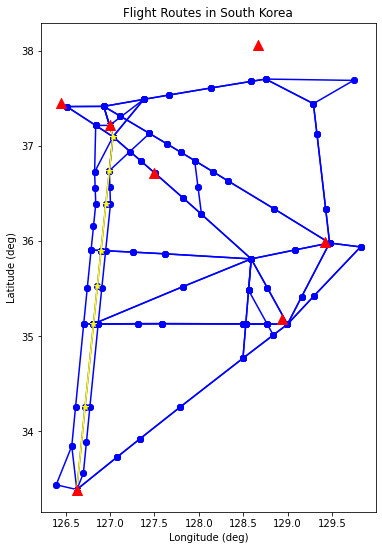

In [16]:
# A* algorithm
def a_star_algorithm(start_node, goal_node, airways):
    open_list = [start_node]
    closed_list = []

    g = {tuple(start_node.values()): 0}
    parents = {tuple(start_node.values()): None}

    # Heuristic function
    def h(node):
        return haversine(node["Longitude (deg)"], node["Latitude (deg)"], goal_node["Longitude (deg)"], goal_node["Latitude (deg)"])

    #Repeat while open_list is not empty
    while open_list:
        #Select the node with the smallest value (g+h) as current_node
        current_node = min(open_list, key=lambda node: g[tuple(node.values())] + h(node))
        
        open_list.remove(current_node)
        closed_list.append(current_node)

        # Return the complete paths if current node = end node
        if current_node == goal_node:
            path = []
            while current_node is not None:
                path.append(current_node)
                current_node = parents[tuple(current_node.values())]
            return path[::-1]

        # Check neighbor and calculate weight values
        neighbors = get_neighbors(current_node, airways)
        for neighbor in neighbors:
            # Calculate the cost from the current node to the neighboring node
            tentative_g_score = g[tuple(current_node.values())] + haversine(
                current_node["Longitude (deg)"], current_node["Latitude (deg)"],
                neighbor["Longitude (deg)"], neighbor["Latitude (deg)"]
            )

            # If the neighbor node is already on closed_list, continue
            if any((neighbor == closed_node) for closed_node in closed_list):
                continue

            # If the neighbor node is not on the open_list, add
            if all((neighbor != open_node) for open_node in open_list):
                open_list.append(neighbor)

            # If there is no g value or smaller, update
            if tuple(neighbor.values()) not in g or tentative_g_score < g[tuple(neighbor.values())]:
                g[tuple(neighbor.values())] = tentative_g_score
                parents[tuple(neighbor.values())] = current_node

    return None

# set start and end airport
start_airport = airports_df[airports_df["IATA"] == "GMP"].iloc[0]
goal_airport = airports_df[airports_df["IATA"] == "CJU"].iloc[0]

# find nearest node
start_node = find_closest_node(start_airport, airways_df)
goal_node = find_closest_node(goal_airport, airways_df)

##### Implement A* algorithm
path = a_star_algorithm(start_node, goal_node, airways_df)
print("Shortest path:", path)


##### visualize
plt.figure(figsize=(6, 9))

longitudes = [point['Longitude (deg)'] for point in path]
latitudes = [point['Latitude (deg)'] for point in path]

# Plot the airways
for idx, row in airways_df.iterrows():
    plt.plot([row['Start Longitude (deg)'], row['End Longitude (deg)']],
             [row['Start Latitude (deg)'], row['End Latitude (deg)']],
             marker='o', color='blue', zorder=1)

# plot path
plt.plot(longitudes, latitudes, color='yellow', marker='*', linestyle='-', zorder=2) 

# plot - airports
plt.scatter(airports_df['Longitude (deg)'], airports_df['Latitude (deg)'], color='red', marker='^', s=100, zorder=3)

# Add labels and title
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.title('Flight Routes in South Korea')
plt.show()


In [17]:
#print path
numeric_path = [(point['Longitude (deg)'], point['Latitude (deg)']) for point in path]
numeric_path

[(126.9931833, 37.21361389),
 (127.0316667, 37.09436944),
 (126.9909903, 36.73705139),
 (126.9514333, 36.38625278),
 (126.8969425, 35.89779972),
 (126.8553833, 35.52115),
 (126.8121194, 35.12623581),
 (126.7170492, 34.25407056),
 (126.6241196, 33.38460522)]

In [18]:
# Total tistance
total_distance = 0
for i in range(len(path) - 1):
    lon1, lat1 = path[i]['Longitude (deg)'], path[i]['Latitude (deg)']
    lon2, lat2 = path[i + 1]['Longitude (deg)'], path[i + 1]['Latitude (deg)']
    total_distance += haversine(lon1, lat1, lon2, lat2)

print(f"Total distance (code2): {total_distance} km")

Total distance (code2): 427.85374155469265 km


### 2) Under severe weather condition

In [24]:
# polygon
def is_inside_polygon(point, polygon):
    return polygon.contains(Point(point["Longitude (deg)"], point["Latitude (deg)"]))

Shortest path: [{'Longitude (deg)': 126.9931833, 'Latitude (deg)': 37.21361389}, {'Longitude (deg)': 127.0316667, 'Latitude (deg)': 37.09436944}, {'Longitude (deg)': 127.348575, 'Latitude (deg)': 36.83835833}, {'Longitude (deg)': 127.500925, 'Latitude (deg)': 36.71436667}, {'Longitude (deg)': 127.8191722, 'Latitude (deg)': 36.45342222}, {'Longitude (deg)': 128.0299697, 'Latitude (deg)': 36.27914028}, {'Longitude (deg)': 128.5907703, 'Latitude (deg)': 35.80983494}, {'Longitude (deg)': 128.5609923, 'Latitude (deg)': 35.47970869}, {'Longitude (deg)': 128.529722, 'Latitude (deg)': 35.1266665}, {'Longitude (deg)': 128.4976922, 'Latitude (deg)': 34.76535483}, {'Longitude (deg)': 127.792902, 'Latitude (deg)': 34.25466028}, {'Longitude (deg)': 127.331378, 'Latitude (deg)': 33.91454919}, {'Longitude (deg)': 127.0730556, 'Latitude (deg)': 33.72222222}, {'Longitude (deg)': 126.6241196, 'Latitude (deg)': 33.38460522}]


Text(0.5, 1.0, 'Flight Routes in South Korea (Under Severe Weather Conditions)')

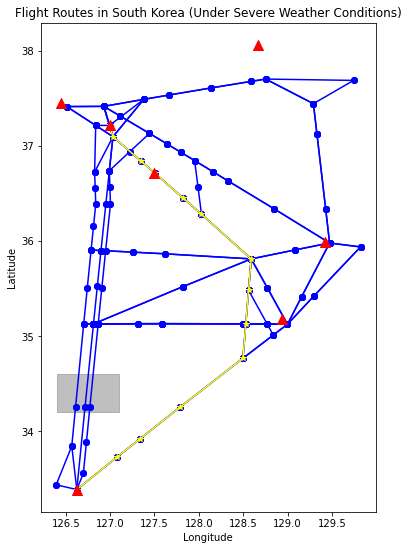

In [25]:
# A* algorithm
def a_star_algorithm(start_node, goal_node, airways, forbidden_polygon):
    open_list = [start_node]
    closed_list = []

    g = {tuple(start_node.values()): 0}
    parents = {tuple(start_node.values()): None}

    # Heuristic function
    def h(node):
        return haversine(node["Longitude (deg)"], node["Latitude (deg)"], goal_node["Longitude (deg)"], goal_node["Latitude (deg)"])

    #Repeat while open_list is not empty
    while open_list:
        #Select the node with the smallest value (g+h) as current_node
        current_node = min(open_list, key=lambda node: g[tuple(node.values())] + h(node))
        
        open_list.remove(current_node)
        closed_list.append(current_node)

        # Return the complete paths if current node = end node
        if current_node == goal_node:
            path = []
            while current_node is not None:
                path.append(current_node)
                current_node = parents[tuple(current_node.values())]
            return path[::-1]

        # Check neighbor and calculate weight values
        neighbors = get_neighbors(current_node, airways)
        for neighbor in neighbors:
            # check polygon
            if is_inside_polygon(neighbor, forbidden_polygon):
                continue
            
            # Calculate the cost from the current node to the neighboring node
            tentative_g_score = g[tuple(current_node.values())] + haversine(
                current_node["Longitude (deg)"], current_node["Latitude (deg)"],
                neighbor["Longitude (deg)"], neighbor["Latitude (deg)"]
            )
            
            # If the neighbor node is already on closed_list, continue
            if any((neighbor == closed_node) for closed_node in closed_list):
                continue
            
            # If the neighbor node is not on the open_list, add
            if all((neighbor != open_node) for open_node in open_list):
                open_list.append(neighbor)
            
            # If there is no g value or smaller, update
            if tuple(neighbor.values()) not in g or tentative_g_score < g[tuple(neighbor.values())]:
                g[tuple(neighbor.values())] = tentative_g_score
                parents[tuple(neighbor.values())] = current_node

    return None

# create polygon
forbidden_polygon = Polygon([(126.4, 34.6), (127.1, 34.6), (127.1, 34.2), (126.4, 34.2)])

# start and end airport  
start_airport = airports_df[airports_df["IATA"] == "GMP"].iloc[0]
goal_airport = airports_df[airports_df["IATA"] == "CJU"].iloc[0]

# find nearest node
start_node = find_closest_node(start_airport, airways_df)
goal_node = find_closest_node(goal_airport, airways_df)

# A* algorithm implementing
path = a_star_algorithm(start_node, goal_node, airways_df, forbidden_polygon)
print("Shortest path:", path)

plt.figure(figsize=(6, 9))


longitudes = [point['Longitude (deg)'] for point in path]
latitudes = [point['Latitude (deg)'] for point in path]

# Plot the airways
for idx, row in airways_df.iterrows():
    plt.plot([row['Start Longitude (deg)'], row['End Longitude (deg)']],
             [row['Start Latitude (deg)'], row['End Latitude (deg)']],
             marker='o', color='blue', zorder=1)
# plot path
plt.plot(longitudes, latitudes, color='yellow', marker='*', linestyle='-', zorder=2) 

# plot airports
plt.scatter(airports_df['Longitude (deg)'], airports_df['Latitude (deg)'], color='red', marker='^', s=100, zorder=3)

# draw polygon
x, y = forbidden_polygon.exterior.xy
plt.fill(x, y, color='gray', alpha=0.5, zorder=0)

# legentd
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.title('Flight Routes in South Korea (Under Severe Weather Conditions)')


In [26]:
#print path
numeric_path = [(point['Longitude (deg)'], point['Latitude (deg)']) for point in path]
numeric_path

[(126.9931833, 37.21361389),
 (127.0316667, 37.09436944),
 (127.348575, 36.83835833),
 (127.500925, 36.71436667),
 (127.8191722, 36.45342222),
 (128.0299697, 36.27914028),
 (128.5907703, 35.80983494),
 (128.5609923, 35.47970869),
 (128.529722, 35.1266665),
 (128.4976922, 34.76535483),
 (127.792902, 34.25466028),
 (127.331378, 33.91454919),
 (127.0730556, 33.72222222),
 (126.6241196, 33.38460522)]

In [27]:
# Total tistance
total_distance = 0
for i in range(len(path) - 1):
    lon1, lat1 = path[i]['Longitude (deg)'], path[i]['Latitude (deg)']
    lon2, lat2 = path[i + 1]['Longitude (deg)'], path[i + 1]['Latitude (deg)']
    total_distance += haversine(lon1, lat1, lon2, lat2)

print(f"Total distance (code2): {total_distance} km")

Total distance (code2): 560.7155840514827 km


# 3. DIJKSTRA algorithm

### 1) Without weather condition and Total Distance

Shortest path: [{'Longitude (deg)': 126.9931833, 'Latitude (deg)': 37.21361389}, {'Longitude (deg)': 127.0316667, 'Latitude (deg)': 37.09436944}, {'Longitude (deg)': 126.9909903, 'Latitude (deg)': 36.73705139}, {'Longitude (deg)': 126.9514333, 'Latitude (deg)': 36.38625278}, {'Longitude (deg)': 126.8969425, 'Latitude (deg)': 35.89779972}, {'Longitude (deg)': 126.8553833, 'Latitude (deg)': 35.52115}, {'Longitude (deg)': 126.8121194, 'Latitude (deg)': 35.12623581}, {'Longitude (deg)': 126.7170492, 'Latitude (deg)': 34.25407056}, {'Longitude (deg)': 126.6241196, 'Latitude (deg)': 33.38460522}]
Total distance: 427.85374155469265 km


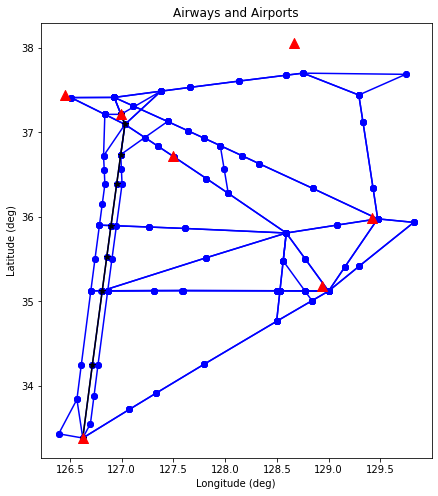

In [30]:
# Dijkstra's algorithm
def dijkstra_algorithm(start_node, goal_node, airways):
    pq = []
    heapq.heappush(pq, (0, start_node))
    g = {tuple(start_node.values()): 0}
    parents = {tuple(start_node.values()): None}
    
    # Repeat while qp is not empty
    while pq:
        current_g, current_node = heapq.heappop(pq)
        
        # Return the complete paths if current node = end node
        if current_node == goal_node:
            path = []
            total_distance = current_g
            while current_node is not None:
                path.append(current_node)
                current_node = parents[tuple(current_node.values())]
            return path[::-1], total_distance
        
        # Check neighbor and calculate weight values
        neighbors = get_neighbors(current_node, airways)
        # Calculate the cost from the current node to the neighboring node
        for neighbor in neighbors:
            tentative_g = current_g + haversine(current_node["Longitude (deg)"], current_node["Latitude (deg)"],
                                                neighbor["Longitude (deg)"], neighbor["Latitude (deg)"])
            # If there is no g value or smaller, update
            if tuple(neighbor.values()) not in g or tentative_g < g[tuple(neighbor.values())]:
                g[tuple(neighbor.values())] = tentative_g
                parents[tuple(neighbor.values())] = current_node
                heapq.heappush(pq, (tentative_g, neighbor))
                
    return None, 0  # Return None if no path is found

# Set the start and goal airports (e.g., from GMP to CJU)
start_airport = airports_df[airports_df["IATA"] == "GMP"].iloc[0]
goal_airport = airports_df[airports_df["IATA"] == "CJU"].iloc[0]

# Find the closest nodes to the start and goal airports
start_node = find_closest_node(start_airport, airways_df)
goal_node = find_closest_node(goal_airport, airways_df)

# Run Dijkstra's algorithm
path, total_distance = dijkstra_algorithm(start_node, goal_node, airways_df)
print("Shortest path:", path)
print("Total distance:", total_distance, "km")

# Visualize the path
plt.figure(figsize=(7, 8))

longitudes = [point['Longitude (deg)'] for point in path]
latitudes = [point['Latitude (deg)'] for point in path]

# Plot the airways
for idx, row in airways_df.iterrows():
    plt.plot([row['Start Longitude (deg)'], row['End Longitude (deg)']],
             [row['Start Latitude (deg)'], row['End Latitude (deg)']],
             marker='o', color='blue', zorder=1)
    
# Plot the path
plt.plot(longitudes, latitudes, color='black', marker='*', linestyle='-', zorder=2)

# Plot the airports
plt.scatter(airports_df['Longitude (deg)'], airports_df['Latitude (deg)'], color='red', marker='^', s=100, zorder=3)

plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.title('Airways and Airports')
plt.show()


### 2) With weather condition and Total Distance

Shortest path: [{'Longitude (deg)': 126.9931833, 'Latitude (deg)': 37.21361389}, {'Longitude (deg)': 127.0316667, 'Latitude (deg)': 37.09436944}, {'Longitude (deg)': 127.348575, 'Latitude (deg)': 36.83835833}, {'Longitude (deg)': 127.500925, 'Latitude (deg)': 36.71436667}, {'Longitude (deg)': 127.8191722, 'Latitude (deg)': 36.45342222}, {'Longitude (deg)': 128.0299697, 'Latitude (deg)': 36.27914028}, {'Longitude (deg)': 128.5907703, 'Latitude (deg)': 35.80983494}, {'Longitude (deg)': 128.5609923, 'Latitude (deg)': 35.47970869}, {'Longitude (deg)': 128.529722, 'Latitude (deg)': 35.1266665}, {'Longitude (deg)': 128.4976922, 'Latitude (deg)': 34.76535483}, {'Longitude (deg)': 127.792902, 'Latitude (deg)': 34.25466028}, {'Longitude (deg)': 127.331378, 'Latitude (deg)': 33.91454919}, {'Longitude (deg)': 127.0730556, 'Latitude (deg)': 33.72222222}, {'Longitude (deg)': 126.6241196, 'Latitude (deg)': 33.38460522}]
Total distance: 560.7155840514827 km


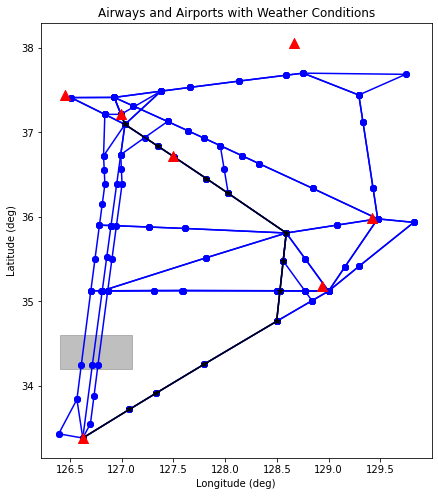

In [31]:
# Dijkstra's algorithm with weather conditions
def dijkstra_algorithm(start_node, goal_node, airways, forbidden_polygon):
    pq = []
    heapq.heappush(pq, (0, start_node))
    g = {tuple(start_node.values()): 0}
    parents = {tuple(start_node.values()): None}
    
    # Repeat while qp is not empty
    while pq:
        current_g, current_node = heapq.heappop(pq)
        
        # Return the complete paths if current node = end node
        if current_node == goal_node:
            path = []
            total_distance = current_g
            while current_node is not None:
                path.append(current_node)
                current_node = parents[tuple(current_node.values())]
            return path[::-1], total_distance
        
        # Check neighbor and calculate weight values
        neighbors = get_neighbors(current_node, airways)
        
        # check polygon
        for neighbor in neighbors:
            if is_inside_polygon(neighbor, forbidden_polygon):
                continue
            
            # Calculate the cost from the current node to the neighboring node
            tentative_g = current_g + haversine(current_node["Longitude (deg)"], current_node["Latitude (deg)"],
                                                neighbor["Longitude (deg)"], neighbor["Latitude (deg)"])
            # If there is no g value or smaller, update
            if tuple(neighbor.values()) not in g or tentative_g < g[tuple(neighbor.values())]:
                g[tuple(neighbor.values())] = tentative_g
                parents[tuple(neighbor.values())] = current_node
                heapq.heappush(pq, (tentative_g, neighbor))
                
    return None, 0  # Return None if no path is found

# Define the forbidden polygon
forbidden_polygon = Polygon([(126.4, 34.6), (127.1, 34.6), (127.1, 34.2), (126.4, 34.2)])

# Set the start and goal airports (e.g., from GMP to CJU)
start_airport = airports_df[airports_df["IATA"] == "GMP"].iloc[0]
goal_airport = airports_df[airports_df["IATA"] == "CJU"].iloc[0]

# Find the closest nodes to the start and goal airports
start_node = find_closest_node(start_airport, airways_df)
goal_node = find_closest_node(goal_airport, airways_df)

# Run Dijkstra's algorithm
path, total_distance = dijkstra_algorithm(start_node, goal_node, airways_df, forbidden_polygon)
print("Shortest path:", path)
print("Total distance:", total_distance, "km")

# Visualize the path
plt.figure(figsize=(7, 8))

longitudes = [point['Longitude (deg)'] for point in path]
latitudes = [point['Latitude (deg)'] for point in path]

# Plot the airways
for idx, row in airways_df.iterrows():
    plt.plot([row['Start Longitude (deg)'], row['End Longitude (deg)']],
             [row['Start Latitude (deg)'], row['End Latitude (deg)']],
             marker='o', color='blue', zorder=1)
    
# Plot the path
plt.plot(longitudes, latitudes, color='black', marker='*', linestyle='-', zorder=2)

# Plot the airports
plt.scatter(airports_df['Longitude (deg)'], airports_df['Latitude (deg)'], color='red', marker='^', s=100, zorder=3)

# Plot the forbidden polygon
x, y = forbidden_polygon.exterior.xy
plt.fill(x, y, color='gray', alpha=0.5, zorder=0)

plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.title('Airways and Airports with Weather Conditions')
plt.show()